In [1]:
import numpy as np
from keras.datasets import mnist
from sklearn import linear_model, preprocessing, metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mnist_util import *

In [2]:
# 1a - load dataset and transform to desired form
"""
Loading MNIST through Keras is easy. We can then transform the
data into the form described, AX = B, where A is the data matrix
of vectorized images, B is the binarized matrix of class labels,
and X represents our model mapping from image space to label space.
"""

# load mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# build data matrices
m, x, y = train_X.shape
train_A = np.reshape(train_X, (m,x*y))
train_A = train_A

m, x, y = test_X.shape
test_A = np.reshape(test_X, (m,x*y))
test_A = test_A

# build output matrices
lb = preprocessing.LabelBinarizer()
lb.fit(train_y)
train_B = lb.transform(train_y)

lb = preprocessing.LabelBinarizer()
lb.fit(test_y)
test_B = lb.transform(test_y)

# dict to store error from different models
err_dict = dict()

In [3]:
# 1b - solve Ax = b with Lasso
"""
"""

# solve with lasso
model_name = "Lasso alpha=0.1"
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_A, train_B)
X = reg.coef_.T

# look at results
train_pred = train_A @ X
train_err = metrics.mean_squared_error(train_B, train_pred)
print(f"{model_name} training error: {train_err}")

test_pred = test_A @ X
test_err = metrics.mean_squared_error(test_B, test_pred)
print(f"{model_name} test set error: {test_err}")

err_dict[model_name] = {
    "train_err": train_err,
    "test_err": test_err,
    "X": np.array(X)
}

Lasso training error: 0.058033726762576156
Lasso test set error: 0.05791847646055155


In [4]:
# 1c - solve Ax = b with pseudo-inverse
"""
"""

# dict to store error from different models
model_name = "Pseudo-inverse"

# solve with pseudo-inverse
X = np.linalg.pinv(train_A) @ train_B

# look at results
train_pred = train_A @ X
train_err = metrics.mean_squared_error(train_B, train_pred)
print(f"{model_name} training error: {train_err}")

test_pred = test_A @ X
test_err = metrics.mean_squared_error(test_B, test_pred)
print(f"{model_name} test set error: {test_err}")

err_dict[model_name] = {
    "train_err": train_err,
    "test_err": test_err,
    "X": np.array(X)
}

Pseudo-inverse training error: 0.03910037240057712
Pseudo-inverse test set error: 0.039518815962724954


In [5]:
# 1d - solve Ax = b with ridge model
"""
"""

# solve with ridge model
model_name = "Ridge"
clf = linear_model.Ridge(alpha=1.0)
clf.fit(train_A, train_B)
X = clf.coef_.T

# look at results
train_pred = train_A @ X
train_err = metrics.mean_squared_error(train_B, train_pred)
print(f"{model_name} training error: {train_err}")

test_pred = test_A @ X
test_err = metrics.mean_squared_error(test_B, test_pred)
print(f"{model_name} test set error: {test_err}")

err_dict[model_name] = {
    "train_err": train_err,
    "test_err": test_err,
    "X": np.array(X)
}

Ridge training error: 0.05872788257727567
Ridge test set error: 0.05936360795437534


In [139]:
train_pred = train_A @ X
train_err = np.linalg.norm(train_pred - train_B) / np.linalg.norm(train_B)
print(f"Pseudo-inverse training error: {train_err}")

test_pred = test_A @ X
test_err = np.linalg.norm(test_pred - test_B) / np.linalg.norm(test_B)
print(f"Pseudo-inverse test set error: {test_err}")

test_acc = metrics.mean_squared_error(test_B, test_pred)
print(test_acc)

Pseudo-inverse training error: 0.6253029058030758
Pseudo-inverse test set error: 0.6286399284385695
0.039518815962724954


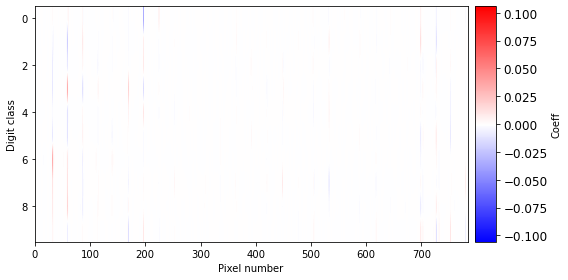

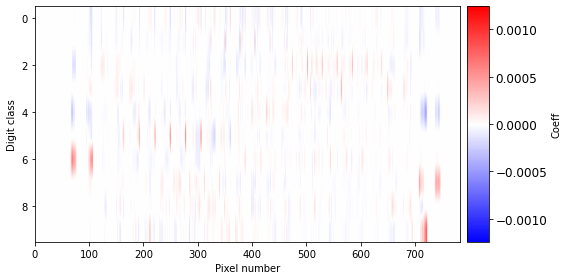

In [125]:
plot_mapping(err_dict["pinv"]["X"])
plot_mapping(err_dict["lasso"]["X"])

In [10]:
# 1e - solve Ax = b with numpy lstsq
"""
"""

# solve with numpy lstsq solve
model_name = "Numpy Linalg Least-squares"
X = np.linalg.lstsq(train_A, train_B, rcond=None)[0]

# look at results
train_pred = train_A @ X
train_err = metrics.mean_squared_error(train_B, train_pred)
print(f"{model_name} training error: {train_err}")

test_pred = test_A @ X
test_err = metrics.mean_squared_error(test_B, test_pred)
print(f"{model_name} test set error: {test_err}")

err_dict[model_name] = {
    "train_err": train_err,
    "test_err": test_err,
    "X": np.array(X)
}

Numpy Linalg Least-squares training error: 0.03910037240057711
Numpy Linalg Least-squares test set error: 0.039518815962724954


In [13]:
def plot_model_error(err_dict, err_type="test"):
    
    # fig
    fig, ax = plt.subplots(figsize=(8,5))
    ax.axhline(y=0, color="k", linestyle="--", alpha=0.2)
    xpos, width = 0, 1/len(err_dict)
    labels, ticks = [], []

    # different iterations k
    for slvr in err_dict.keys():

        # error
        err = err_dict[slvr][f"{err_type}_err"]

        # plot
        labels.append(slvr)
        ticks.append(xpos)
        ax.bar(xpos, err, width, label=slvr)
        xpos += 0.5

    # plot info
    ax.set_xlabel("Model")
    ax.set_ylabel(f"{err_type.capitalize()} mean squared error")
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yscale("log")

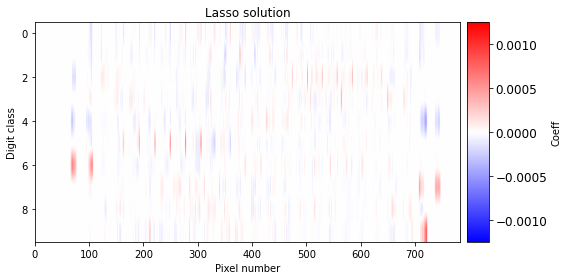

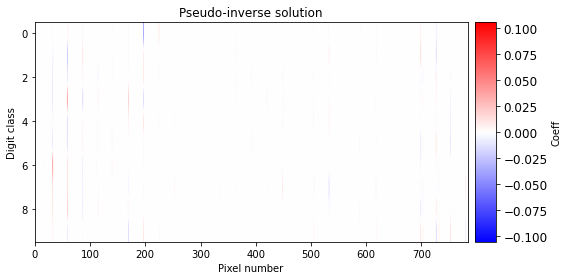

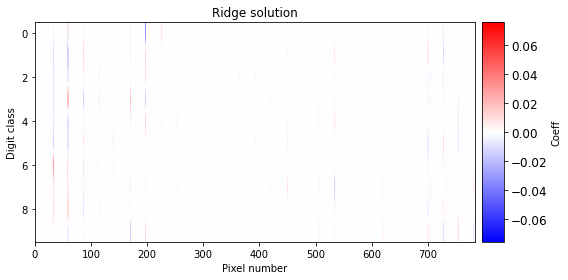

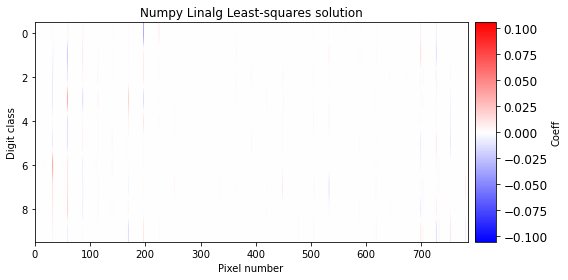

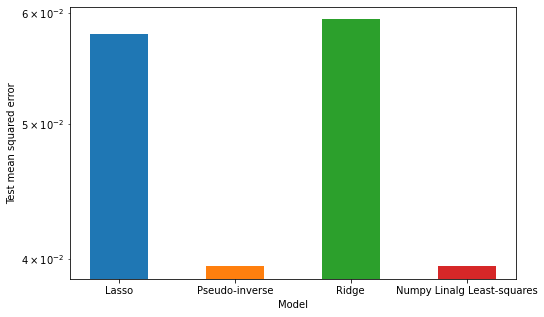

In [14]:
# 1f - visualizations

# visualize solutions from above solvers
for slvr in err_dict.keys():
    plot_mapping(err_dict[slvr]["X"], slvr)

# compare error
plot_model_error(err_dict)

Lasso alpha=3 training error: 0.0668909738494081
Lasso alpha=3 test set error: 0.06662435343712095


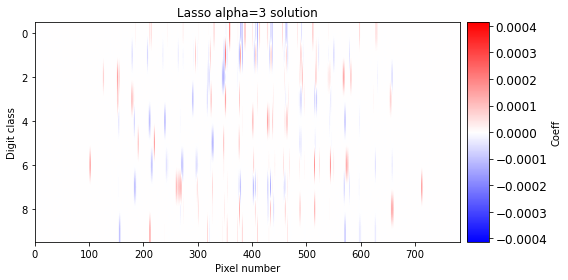

In [20]:
# 2a - promote sparsity to determine most informative mnist pixels
"""
We can promote sparsity by using the Lasso solver with a high alpha
value.
"""

# solve with lasso, alpha=20
alpha = 3
model_name = f"Lasso alpha={alpha}"
reg = linear_model.Lasso(alpha=alpha)
reg.fit(train_A, train_B)
X = reg.coef_.T

# look at results
train_pred = train_A @ X
train_err = metrics.mean_squared_error(train_B, train_pred)
print(f"{model_name} training error: {train_err}")

test_pred = test_A @ X
test_err = metrics.mean_squared_error(test_B, test_pred)
print(f"{model_name} test set error: {test_err}")

err_dict[model_name] = {
    "train_err": train_err,
    "test_err": test_err,
    "X": np.array(X)
}

plot_mapping(X, model_name)

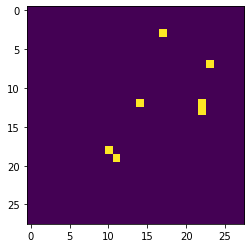

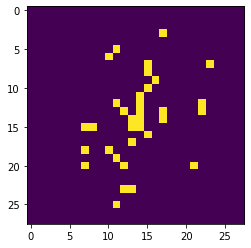

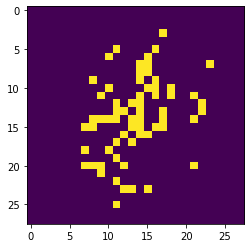

In [139]:
# 2b - rank informative pixels
"""
Approach:
- sort pixels based on coefficients in sparse mapping
- visualize highest N% of "important" pixels with imshow
- mask the remaining pixels and perform test data classification
- compare error from masked test data to unmasked for different values of N
"""

# sort the sparse model based on coeffs
X = np.abs(err_dict["Lasso alpha=3"]["X"])
X_idx = np.unravel_index(np.argsort(X, axis=None), X.shape)

# analyze different percentages of top pixels
pct_arr = [0.1, 0.5, 1]
for pct in pct_arr:
    
    # visualize top pct% of pixels
    n = int((pct / 100.) * X.size)
    # top_pixels = list(reversed(list(zip(X_idx[0][int(-n):], X_idx[1][int(-n):]))))
    # mask = np.zeros_like(X)
    top_pixels = np.unravel_index(X_idx[0][-n:], train_X[0].shape)
    mask = np.zeros_like(train_X[0])
    mask[top_pixels[0], top_pixels[1]] = 1
    plt.imshow(mask)
    plt.show()